In [52]:
#IMPORTS
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors, Crippen, GraphDescriptors
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to extract molecular descriptors
def compute_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None  # Skip invalid molecules
    
    return {
        "MolWt": Descriptors.MolWt(mol),  # Molecular Weight
        "NumRings": rdMolDescriptors.CalcNumRings(mol),  # Total Rings
        "NumAromaticRings": rdMolDescriptors.CalcNumAromaticRings(mol),  # Aromatic Rings
        "TPSA": rdMolDescriptors.CalcTPSA(mol),  # Topological Polar Surface Area
        "LogP": Crippen.MolLogP(mol),  # Lipophilicity
        "MolarRefractivity": Crippen.MolMR(mol),  # Molar Refractivity
        "NumRotatableBonds": rdMolDescriptors.CalcNumRotatableBonds(mol),  # Flexibility
        "NumHAcceptors": Descriptors.NumHAcceptors(mol),  # H-bond Acceptors
        "NumHDonors": Descriptors.NumHDonors(mol),  # H-bond Donors
        "FractionCSP3": rdMolDescriptors.CalcFractionCSP3(mol),  # sp3 Hybridization
        "FormalCharge": Chem.rdmolops.GetFormalCharge(mol),  # Net Charge
        "NumRadicalElectrons": Descriptors.NumRadicalElectrons(mol),  # Radical Electrons

        # Electronic Descriptors
        "Electronegativity_Proxy": sum(atom.GetAtomicNum() for atom in mol.GetAtoms()) / Chem.rdchem.Mol.GetNumAtoms(mol),  
        "Polarizability_Proxy": rdMolDescriptors.CalcExactMolWt(mol) / Chem.rdchem.Mol.GetNumAtoms(mol),
        "BalabanJ": GraphDescriptors.BalabanJ(mol), #Molecular Connectivity
        "BertzCT": GraphDescriptors.BertzCT(mol),  # BertzCT Index (Connectivity)
    }


In [30]:
#Load Data and Extract Features
train_data = pd.read_csv("smiles_train.csv")
features = train_data["smile"].apply(compute_descriptors).apply(pd.Series)
train_data = pd.concat([train_data, features], axis=1)

valid_data = pd.read_csv("smiles_valid.csv")
features = valid_data["smile"].apply(compute_descriptors).apply(pd.Series)
valid_data = pd.concat([valid_data, features], axis=1)

test_data = pd.read_csv("smiles_test.csv")
features = test_data["smile"].apply(compute_descriptors).apply(pd.Series)
test_data = pd.concat([test_data, features], axis=1)

In [42]:
# Remove sparse features 
train_data = train_data.drop(columns=['homo_extrapolated', 'lumo_extrapolated', 'gap_extrapolated', 'optical_lumo_extrapolated'])
valid_data = valid_data.drop(columns=['homo_extrapolated', 'lumo_extrapolated', 'gap_extrapolated', 'optical_lumo_extrapolated'])
test_data = test_data.drop(columns=['homo_extrapolated', 'lumo_extrapolated', 'gap_extrapolated', 'optical_lumo_extrapolated'])

In [48]:
#K-Means Clustering on Raw Data
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Extracting features and excluding the SMILES column and the features we want to predict 
X = train_data.drop(columns=['smile', 'spectral_overlap', 'gap', 'homo', 'lumo'])

# Standardizing the data (important for K-Means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

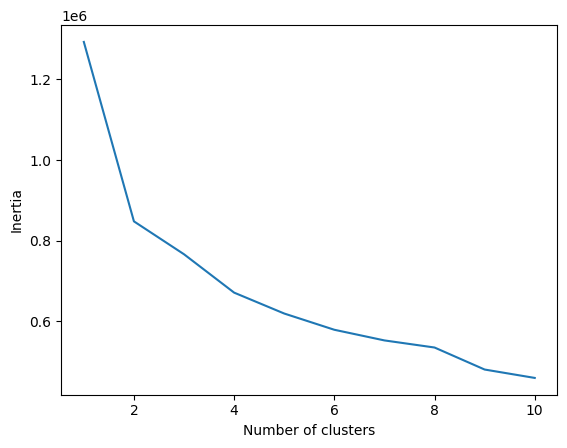

In [49]:
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Inertia Plot')
plt.show()

In [50]:
# Perform K-Means clustering with K=2
kmeans = KMeans(n_clusters=2, random_state=42)
train_data['Cluster'] = kmeans.fit_predict(X_scaled)

# Check the silhouette score to evaluate the clustering
silhouette = silhouette_score(X_scaled, train_data['Cluster'])
print(f'Silhouette Score: {silhouette}')

# Check the cluster centroids
print(f'Cluster Centroids: {kmeans.cluster_centers_}')

Silhouette Score: 0.31375502302128566
Cluster Centroids: [[ 0.82282262  0.8338595   0.76635723  0.2453786   0.68527175  0.84583538
   0.61697346  0.63624119  0.10245178 -0.14000503  0.         -0.01854645
   0.01828407  0.02829609 -0.75814907  0.8160981  -0.90033964]
 [-0.74575517 -0.75575831 -0.69457845 -0.22239588 -0.62108763 -0.76661251
  -0.55918632 -0.57664939 -0.09285591  0.12689184  0.          0.01680935
  -0.01657155 -0.02564581  0.6871391  -0.73966049  0.81601177]]


Explained variance per component: [0.46676075 0.15479652 0.09209465 0.07468286 0.06275594 0.05297972
 0.03618711 0.02549075]
Total variance explained: 0.97


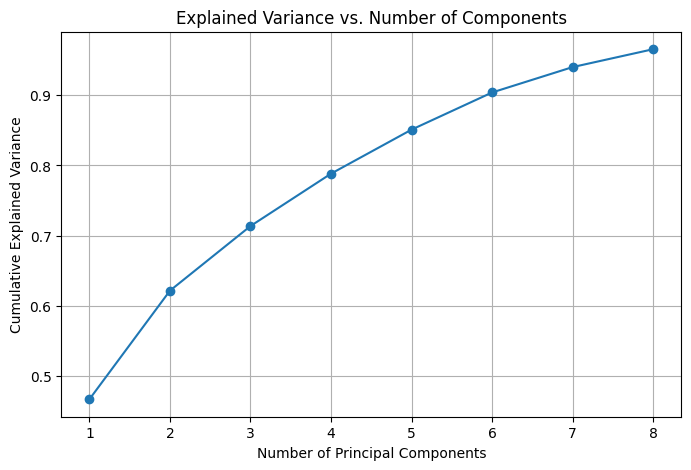

In [59]:
#PCA for Feature Selection
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# # Create a DataFrame with principal components
# pca_df = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])])

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
print(f'Explained variance per component: {explained_variance}')
print(f'Total variance explained: {sum(explained_variance):.2f}')


# Plot cumulative explained variance
nums = np.arange(1, 9)
plt.figure(figsize=(8,5))
plt.plot(nums, np.cumsum(explained_variance), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid()
plt.show()


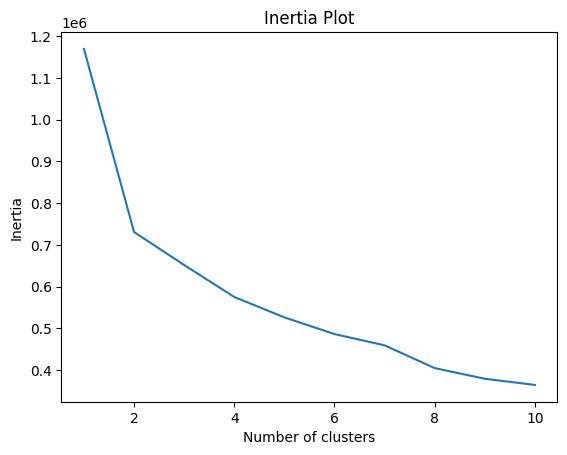

In [60]:
#Use principle components for KMeans analysis

pca = PCA(n_components=6)  # Keep 6 principal components
X_pca = pca.fit_transform(X_scaled)

#Determine optimal k using principle components
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Inertia Plot')
plt.show()

In [62]:
# Add cluster labels to the original dataframe
train_data['Cluster'] = kmeans.fit_predict(X_pca)
silhouette = silhouette_score(X_scaled, train_data['Cluster'])
print(f'Silhouette Score: {silhouette}')
print(f'Cluster Centroids: {kmeans.cluster_centers_}')

Silhouette Score: 0.3137077221933785
Cluster Centroids: [[ 2.57537338 -0.06238453  0.02830184  0.0392938   0.11225101 -0.05013231]
 [-2.09909501  0.0508474  -0.02306782 -0.03202698 -0.09149179  0.04086106]]


              gap           spectral_overlap             
             mean       std             mean          std
Cluster                                                  
0        1.970770  0.402900      6069.368243  3615.605719
1        2.387173  0.532494      1943.200057  1465.480520


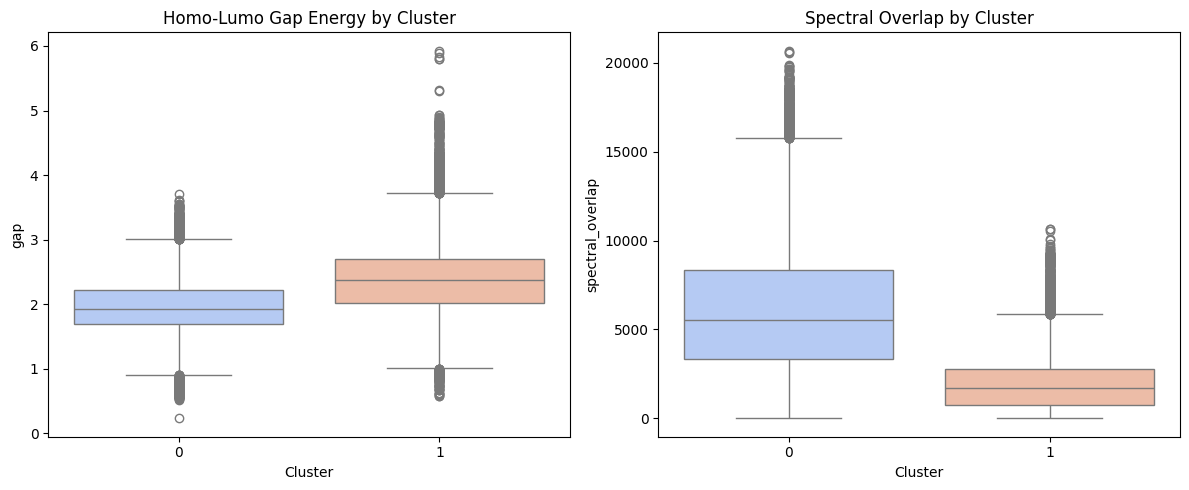

In [65]:
cluster_summary = train_data.groupby('Cluster')[['gap', 'spectral_overlap']].agg(['mean', 'std'])
print(cluster_summary)

plt.figure(figsize=(12,5))

# Band Gap Energy
plt.subplot(1, 2, 1)
sns.boxplot(x='Cluster', y='gap', data=train_data, hue='Cluster', palette='coolwarm', legend=False)
plt.title('Homo-Lumo Gap Energy by Cluster')

# Absorption Efficiency
plt.subplot(1, 2, 2)
sns.boxplot(x='Cluster', y='spectral_overlap', data=train_data, hue='Cluster', palette='coolwarm', legend=False)
plt.title('Spectral Overlap by Cluster')

plt.tight_layout()
plt.show()


In [125]:
#Check statitical significance
from scipy.stats import ttest_ind

cluster_0 = train_data[train_data['Cluster'] == 0]
cluster_1 = train_data[train_data['Cluster'] == 1]

# Perform t-tests
t_stat_gap, p_value_gap = ttest_ind(cluster_0['gap'], cluster_1['gap'], equal_var=False)
t_stat_so, p_value_so = ttest_ind(cluster_0['spectral_overlap'], cluster_1['spectral_overlap'], equal_var=False)

print(f"Homo-Lump Gap Energy t-test: t={t_stat_gap}, p={p_value_gap}")
print(f"Spectral Overlap t-test: t={t_stat_so}, p={p_value_so}")


Homo-Lump Gap Energy t-test: t=-126.47994069084397, p=0.0
Spectral Overlap t-test: t=204.00122222717567, p=0.0


In [110]:
#Prepare validation and training sets
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(train_data[['gap', 'spectral_overlap']])
X_train = scaler.fit_transform(train_data[['MolWt', 'NumRings',
       'NumAromaticRings', 'TPSA', 'LogP', 'MolarRefractivity',
       'NumRotatableBonds', 'NumHAcceptors', 'NumHDonors', 'FractionCSP3',
       'FormalCharge', 'NumRadicalElectrons', 'Electronegativity_Proxy',
       'Polarizability_Proxy', 'BalabanJ', 'BertzCT']])
y_val = scaler_y.transform(valid_data[['gap', 'spectral_overlap']])
X_val = scaler.transform(valid_data[['MolWt', 'NumRings',
       'NumAromaticRings', 'TPSA', 'LogP', 'MolarRefractivity',
       'NumRotatableBonds', 'NumHAcceptors', 'NumHDonors', 'FractionCSP3',
       'FormalCharge', 'NumRadicalElectrons', 'Electronegativity_Proxy',
       'Polarizability_Proxy', 'BalabanJ', 'BertzCT']])

In [111]:
#Train and Evaluate Neural Network: Initial
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mlp_init = MLPRegressor(hidden_layer_sizes=(64, 64), activation='relu', solver='adam', 
                   max_iter=500, random_state=42)

mlp_init.fit(X_train, y_train)

y_pred = mlp_init.predict(X_val)

# Convert predictions back to original scale
y_pred_original = scaler_y.inverse_transform(y_pred)
y_val_original = scaler_y.inverse_transform(y_val)

# Evaluate performance
mae_gap = mean_absolute_error(y_val_original[:, 0], y_pred_original[:, 0])
mae_spectral_overlap = mean_absolute_error(y_val_original[:, 1], y_pred_original[:, 1])
rmse_gap = np.sqrt(mean_squared_error(y_val_original[:, 0], y_pred_original[:, 0]))
rmse_spectral_overlap = np.sqrt(mean_squared_error(y_val_original[:, 1], y_pred_original[:, 1]))
r2_per_target = r2_score(y_val_original, y_pred_original, multioutput='raw_values')

# Print results
print(f"MAE for gap: {mae_gap:.4f}")
print(f"MAE for spectral_overlap: {mae_spectral_overlap:.4f}")
print(f"RMSE for gap: {rmse_gap:.4f}")
print(f"RMSE for spectral_overlap: {rmse_spectral_overlap:.4f}")
print(f"R² for gap: {r2_per_target[0]:.4f}, R² for spectral_overlap: {r2_per_target[1]:.4f}")

MAE for gap: 0.1767
MAE for spectral_overlap: 444.5075
RMSE for gap: 0.2294
RMSE for spectral_overlap: 625.8417
R² for gap: 0.8056, R² for spectral_overlap: 0.9049


In [112]:
# Manual Feature Selection: Finding more strongly correlated features
train_corr = train_data[['gap', 'spectral_overlap', 'MolWt', 'NumRings',
       'NumAromaticRings', 'TPSA', 'LogP', 'MolarRefractivity',
       'NumRotatableBonds', 'NumHAcceptors', 'NumHDonors', 'FractionCSP3',
       'FormalCharge', 'NumRadicalElectrons', 'Electronegativity_Proxy',
       'Polarizability_Proxy', 'BalabanJ', 'BertzCT']].corr()
high_corr = train_corr[(train_corr.abs() >= 0.5)]
print(high_corr[['gap', 'spectral_overlap']].dropna(how='all'))

                        gap  spectral_overlap
gap                1.000000               NaN
spectral_overlap        NaN          1.000000
MolWt             -0.503743          0.724486
NumRings          -0.500335          0.731082
NumAromaticRings        NaN          0.630886
LogP                    NaN          0.606275
MolarRefractivity       NaN          0.760097
NumRotatableBonds       NaN          0.543762
NumHAcceptors     -0.500401          0.531462
BalabanJ                NaN         -0.683023
BertzCT           -0.502618          0.700291


In [113]:
#Train and Evaluate Neural Network: Using Selected Features
X_train = scaler.fit_transform(train_data[['MolWt', 'NumRings',
       'NumAromaticRings', 'LogP', 'MolarRefractivity',
       'NumRotatableBonds', 'NumHAcceptors',
       'BalabanJ', 'BertzCT']])
X_val = scaler.transform(valid_data[['MolWt', 'NumRings',
       'NumAromaticRings', 'LogP', 'MolarRefractivity',
       'NumRotatableBonds', 'NumHAcceptors',
       'BalabanJ', 'BertzCT']])

mlp_2 = MLPRegressor(hidden_layer_sizes=(64, 64), activation='relu', solver='adam', 
                   max_iter=500, random_state=42)
mlp_2.fit(X_train, y_train)

y_pred = mlp_2.predict(X_val)
y_pred_original = scaler_y.inverse_transform(y_pred)
y_val_original = scaler_y.inverse_transform(y_val)

mae_gap = mean_absolute_error(y_val_original[:, 0], y_pred_original[:, 0])
mae_spectral_overlap = mean_absolute_error(y_val_original[:, 1], y_pred_original[:, 1])
rmse_gap = np.sqrt(mean_squared_error(y_val_original[:, 0], y_pred_original[:, 0]))
rmse_spectral_overlap = np.sqrt(mean_squared_error(y_val_original[:, 1], y_pred_original[:, 1]))
r2_per_target = r2_score(y_val_original, y_pred_original, multioutput='raw_values')

# Print results
print(f"MAE for gap: {mae_gap:.4f}")
print(f"MAE for spectral_overlap: {mae_spectral_overlap:.4f}")
print(f"RMSE for gap: {rmse_gap:.4f}")
print(f"RMSE for spectral_overlap: {rmse_spectral_overlap:.4f}")
print(f"R² for gap: {r2_per_target[0]:.4f}, R² for spectral_overlap: {r2_per_target[1]:.4f}")

MAE for gap: 0.2019
MAE for spectral_overlap: 554.3289
RMSE for gap: 0.2628
RMSE for spectral_overlap: 761.6736
R² for gap: 0.7449, R² for spectral_overlap: 0.8592


In [121]:
#Train and Evaluate Neural Network: Using PCA
X_train = scaler.fit_transform(train_data[['MolWt', 'NumRings',
       'NumAromaticRings', 'TPSA', 'LogP', 'MolarRefractivity',
       'NumRotatableBonds', 'NumHAcceptors', 'NumHDonors', 'FractionCSP3',
       'FormalCharge', 'NumRadicalElectrons', 'Electronegativity_Proxy',
       'Polarizability_Proxy', 'BalabanJ', 'BertzCT']])
X_val = scaler.transform(valid_data[['MolWt', 'NumRings',
       'NumAromaticRings', 'TPSA', 'LogP', 'MolarRefractivity',
       'NumRotatableBonds', 'NumHAcceptors', 'NumHDonors', 'FractionCSP3',
       'FormalCharge', 'NumRadicalElectrons', 'Electronegativity_Proxy',
       'Polarizability_Proxy', 'BalabanJ', 'BertzCT']])

#Produce PCA for training and predicting instead of actual features
pca = PCA(n_components=6)
X_train = pca.fit_transform(X_train)
X_val = pca.transform(X_val)

mlp_3 = MLPRegressor(hidden_layer_sizes=(64, 64), activation='relu', solver='adam', 
                   max_iter=500, random_state=42)
mlp_3.fit(X_train, y_train)

y_pred = mlp_3.predict(X_val)
y_pred_original = scaler_y.inverse_transform(y_pred)
y_val_original = scaler_y.inverse_transform(y_val)

mae_gap = mean_absolute_error(y_val_original[:, 0], y_pred_original[:, 0])
mae_spectral_overlap = mean_absolute_error(y_val_original[:, 1], y_pred_original[:, 1])
rmse_gap = np.sqrt(mean_squared_error(y_val_original[:, 0], y_pred_original[:, 0]))
rmse_spectral_overlap = np.sqrt(mean_squared_error(y_val_original[:, 1], y_pred_original[:, 1]))
r2_per_target = r2_score(y_val_original, y_pred_original, multioutput='raw_values')

# Print results
print(f"MAE for gap: {mae_gap:.4f}")
print(f"MAE for spectral_overlap: {mae_spectral_overlap:.4f}")
print(f"RMSE for gap: {rmse_gap:.4f}")
print(f"RMSE for spectral_overlap: {rmse_spectral_overlap:.4f}")
print(f"R² for gap: {r2_per_target[0]:.4f}, R² for spectral_overlap: {r2_per_target[1]:.4f}")

MAE for gap: 0.2514
MAE for spectral_overlap: 688.4684
RMSE for gap: 0.3256
RMSE for spectral_overlap: 967.9445
R² for gap: 0.6084, R² for spectral_overlap: 0.7726


In [123]:
# Final Test: The initial model performed best, so we will use that one
X_train = scaler.fit_transform(train_data[['MolWt', 'NumRings',
       'NumAromaticRings', 'TPSA', 'LogP', 'MolarRefractivity',
       'NumRotatableBonds', 'NumHAcceptors', 'NumHDonors', 'FractionCSP3',
       'FormalCharge', 'NumRadicalElectrons', 'Electronegativity_Proxy',
       'Polarizability_Proxy', 'BalabanJ', 'BertzCT']])
y_test = scaler_y.transform(test_data[['gap', 'spectral_overlap']])
X_test = scaler.transform(test_data[['MolWt', 'NumRings',
       'NumAromaticRings', 'TPSA', 'LogP', 'MolarRefractivity',
       'NumRotatableBonds', 'NumHAcceptors', 'NumHDonors', 'FractionCSP3',
       'FormalCharge', 'NumRadicalElectrons', 'Electronegativity_Proxy',
       'Polarizability_Proxy', 'BalabanJ', 'BertzCT']])

y_pred = mlp_init.predict(X_test)

# Convert predictions back to original scale
y_pred_original = scaler_y.inverse_transform(y_pred)
y_test_original = scaler_y.inverse_transform(y_test)

# Evaluate performance
mae_gap = mean_absolute_error(y_test_original[:, 0], y_pred_original[:, 0])
mae_spectral_overlap = mean_absolute_error(y_test_original[:, 1], y_pred_original[:, 1])
rmse_gap = np.sqrt(mean_squared_error(y_test_original[:, 0], y_pred_original[:, 0]))
rmse_spectral_overlap = np.sqrt(mean_squared_error(y_test_original[:, 1], y_pred_original[:, 1]))
r2_per_target = r2_score(y_test_original, y_pred_original, multioutput='raw_values')

# Print results
print(f"MAE for gap: {mae_gap:.4f}")
print(f"MAE for spectral_overlap: {mae_spectral_overlap:.4f}")
print(f"RMSE for gap: {rmse_gap:.4f}")
print(f"RMSE for spectral_overlap: {rmse_spectral_overlap:.4f}")
print(f"R² for gap: {r2_per_target[0]:.4f}, R² for spectral_overlap: {r2_per_target[1]:.4f}")

MAE for gap: 0.1745
MAE for spectral_overlap: 452.0217
RMSE for gap: 0.2284
RMSE for spectral_overlap: 632.4784
R² for gap: 0.7995, R² for spectral_overlap: 0.9056
